In [1]:
import torch
import torch.nn.functional as F
import random

g = torch.Generator().manual_seed(1337)

In [2]:
class Linear:
  def __init__(self, ins, outs, bias=False):
    self.weights = torch.empty(outs, ins)
    torch.nn.init.kaiming_uniform_(self.weights, mode='fan_in', nonlinearity='relu', generator=g)
    if bias:
      self.biases = torch.rand(outs, generator=g)
    else:
      self.biases = None

  def __call__(self, x):
    pre_act = x @ self.weights.T
    if self.biases is not None:
      pre_act += self.biases
    return pre_act

  def params(self):
    return [self.weights] + [self.biases] if self.biases is not None else [self.weights]

In [3]:
class Relu:
  def __call__(self, x):
    self.out = F.relu(x)
    return self.out

class Softmax:
  def __call__(self, x):
    self.out = F.softmax(x)
    return self.out

In [4]:
class BatchNorm1d:
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.dim = dim
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # gamma & beta: trainable parameters to scale or move the normed batch
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # for inference
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    if self.training:   # train vars
      xmean = x.mean(0, keepdim=True)
      xvar = x.var(0, keepdim=True)
    else:               # inference vars
      xmean = self.running_mean
      xvar = self.running_var

    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta

    if self.training: # calculate running mean/var
      self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
      self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def params(self):
    return [self.gamma] + [self.beta]

In [5]:
# ---------------------------------------------------------------------

In [6]:
with open('turkish_names.txt', 'r') as f:
  lines = f.read().splitlines()
len(lines)

trchr_to_utf8 = {
    'İ': 'i',
    'I': '!',
    'Ö': '@',
    'Ü': '#',
    'Ş': '$',
    'Ç': '^',
    'Ğ': '&'}

words = [word for line in lines for word in line.split()]
names = [''.join(trchr_to_utf8.get(ch, ch) for ch in name).lower() for name in words]
# ^ turkish phonemes transmogrified into utf-8 sigils ^-^
names[:10]

['jale',
 'ali',
 'mahmut',
 'mansur',
 'k#r$ad',
 'gamze',
 'mira^',
 'y#cel',
 'kubilay',
 'hayati']

In [7]:
chars = ['.'] + sorted(list(set(ch for name in names for ch in name)))
# ^ no need to sort tbh.    '.' as special start/end token.
i_to_s = {i: chars[i] for i in range(len(chars))}
s_to_i = {v: k for k, v in i_to_s.items()}

In [8]:
block_size = 3 # how many characters should it take to predict the next one?
# . . . -> a; . . a -> t; . a t -> a
def create_dataset(names):
  X, Y = [], []
  for name in names:
    name = f"{name}."   # add end token to each name
    context = [0] * block_size # initialized as `. . .`
    for ch in name:
      X.append(context)
      Y.append(s_to_i[ch])
      context = context[1:] + [s_to_i[ch]]
  return torch.tensor(X), torch.tensor(Y)

X, Y = create_dataset(names[:5])
X[:10], Y[:10]

(tensor([[ 0,  0,  0],
         [ 0,  0, 16],
         [ 0, 16,  7],
         [16,  7, 18],
         [ 7, 18, 11],
         [ 0,  0,  0],
         [ 0,  0,  7],
         [ 0,  7, 18],
         [ 7, 18, 15],
         [ 0,  0,  0]]),
 tensor([16,  7, 18, 11,  0,  7, 18, 15,  0, 19]))

In [9]:
block_size = 3 # how many characters should it take to predict the next one?
# . . . -> a; . . a -> t; . a t -> a
def create_dataset(names):
  X, Y = [], []
  for name in names:
    name = f"{name}."   # add end token to each name
    context = [0] * block_size # initialized as `. . .`
    for ch in name:
      X.append(context)
      Y.append(s_to_i[ch])
      context = context[1:] + [s_to_i[ch]]
  return torch.tensor(X), torch.tensor(Y)

In [10]:
random.shuffle(names)

n1 = int(len(names) * 0.1)

Xtr, Ytr = create_dataset(names[n1*2:]) # 80% train split
Xte, Yte = create_dataset(names[:n1]) # 10% test
Xval, Yval = create_dataset(names[n1:n1*2]) # 10% valid

# precision spell
avg_len = sum(len(name) + 1 for name in names) / len(names)
actual = (len(Xtr) + len(Xte) + len(Xval)) / len(names)
assert abs(avg_len - actual) < 1e-6, '\nSize mismatch.\nWhat did you break?'

In [11]:
emb_dim = 2 # each character's embedding will be a vector of size (2).
C = torch.rand(len(chars), emb_dim)
emb = C[Xtr].view((Xtr.shape[0], -1))


n_hidden = 100 #neuron count for hidden layers

layers = [
    Linear(emb.shape[1], n_hidden), BatchNorm1d(n_hidden), Relu(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Relu(),
    Linear(n_hidden, len(chars)), BatchNorm1d(len(chars))#, Softmax() SOFTMAX BEFORE CROSSENTROPY??? NO WAY
    ##### TODO : TEST WITH AND WITHOUT BATCHNORM BEFORE SOFTMAX.
]

In [12]:
parameters = []
for layer in layers:
  if hasattr(layer, 'params'):
    parameters.extend(layer.params())
parameters.append(C)

for p in parameters:
  p.requires_grad = True

print(f'{len([p for param in parameters for p in param])} parameters.')

720 parameters.


In [13]:
batch_size = 32
losses = []
for i in range(30000):

  ib = torch.randint(0, emb.shape[0], (batch_size,)) # indices of the elements in the batch
  #emb = C.view
  Xb = C[Xtr[ib]].view(batch_size, -1)
  Yb = Ytr[ib] # initialize batches

# forward pass
  for layer in layers:
    Xb = layer(Xb)
# backward pass
  loss = F.cross_entropy(Xb, Yb)
  loss.backward()
  losses.append(loss.item())
# update
  for p in parameters:
    if i < 25000:
        p.data += -0.01 * p.grad
    else:
        p.data += -0.001 * p.grad

  for p in parameters:
    p.grad = None
  if i%10000 == 0:
    print(f"step {i}\ntrain loss: {loss:.5f}")
    X = C[Xval].view(Xval.shape[0], -1)
    Y = Yval # initialize batches
    # forward pass
    for layer in layers:
        X = layer(X)
    val_loss = F.cross_entropy(X, Y)
    print(f"valid loss: {val_loss:.5f}")

print(f"avg train loss: {sum(losses) / len(losses)}")

step 0
train loss: 3.77297
valid loss: 3.85033
step 10000
train loss: 2.05923
valid loss: 1.94458
step 20000
train loss: 2.03802
valid loss: 1.82128
avg train loss: 2.045708241466681


In [14]:
# Test results
X = C[Xtr].view(Xtr.shape[0], -1)
Y = Ytr # initialize batches
# forward pass
for layer in layers:
    X = layer(X)
# backward pass
loss = F.cross_entropy(X, Y)
print(f"test loss: {loss}")

test loss: 1.70303475856781


In [15]:
utf8_to_trchr = {v: k for k, v in trchr_to_utf8.items()}
def undo_utf8(name: str):
    name = ''.join(utf8_to_trchr.get(ch, ch) for ch in name).lower()
    return name

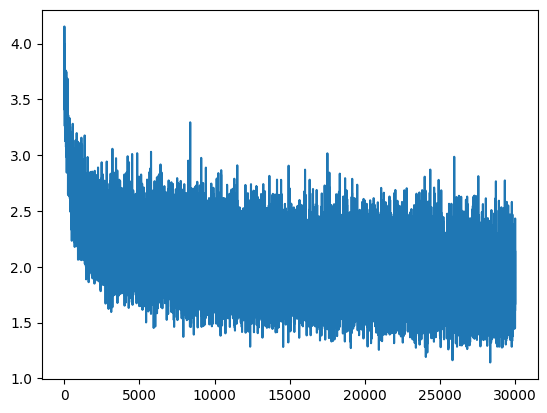

In [17]:
import matplotlib.pyplot as plt

plt.plot(losses)

In [18]:
# ---   INFERENCE   ---
for layer in layers:
  if hasattr(layer, 'training'):
    layer.training = False

while True:
  name_count = int(input("How many names will be generated? (0 to exit): "))
  if name_count == 0:
    break

  for i in range(name_count):
    context = [0] * block_size
    name = ''
    while True:
      emb = C[context].view(-1, block_size * emb_dim)
      for layer in layers:
        emb = layer(emb)
      pred = torch.multinomial(F.softmax(emb, dim=1), 1).item()
      if i_to_s[pred] == '.':
        break
      context = context[1:] + [pred]
      #print(context)
      name += i_to_s[pred]

    name = undo_utf8(name)
    print(name)


How many names will be generated? (0 to exit): 5
nei̇nşan
rerman
ahi̇r
si̇m
ni̇nuç
How many names will be generated? (0 to exit): 5
fer
ci̇m
hüseyi̇ne
zas
bubi̇l
How many names will be generated? (0 to exit): 0
